In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import datetime
import json
import statsmodels.api as sm
import math

# Bonds

In [24]:
bond_etf_symbs = ['BND','AGG','VCIT','BSV','TLT','VCSH','LQD','MUB','BIL','SHY']

In [25]:
for bond in bond_etf_symbs:
    print(yf.Ticker(bond).history(period='max').index[0])

2007-04-10 00:00:00-04:00
2003-09-29 00:00:00-04:00
2009-11-23 00:00:00-05:00
2007-04-10 00:00:00-04:00
2002-07-30 00:00:00-04:00
2009-11-23 00:00:00-05:00
2002-07-30 00:00:00-04:00
2007-09-10 00:00:00-04:00
2007-05-30 00:00:00-04:00
2002-07-30 00:00:00-04:00


In [29]:
bond_mr = {}
for bond in bond_etf_symbs:
    df = yf.Ticker(bond).history(start='2009-12-01')
    index = df.index
    years = []
    months = []
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
    df['Year'] = pd.Series(years,index=index)
    df['Month'] = pd.Series(months,index=index)
    df.reset_index(drop=True,inplace=True)
    df_gbo = df.groupby(['Year','Month'])
    bond_mr[bond] = {}
    for year_it in range(2009,2024):
        if year_it == 2023:
            month_start = 1
            month_end = 5
        else:
            if year_it == 2009:
                month_start = 12
            else:
                month_start = 1
            month_end = 13
        for month_it in range(month_start, month_end):
            df_group = df_gbo.get_group((year_it,month_it))
            fd = df_group.head(1)
            ld = df_group.tail(1)
            ret = (ld['Close'].iloc[0] - fd['Open'].iloc[0])/fd['Open'].iloc[0]
            bond_mr[bond][(year_it,month_it)] = ret

In [30]:
bond_mr

{'BND': {(2009, 12): -0.015168824994313213,
  (2010, 1): 0.01272314102531452,
  (2010, 2): 0.002645109681027505,
  (2010, 3): -0.004148856180426772,
  (2010, 4): 0.010382076786684498,
  (2010, 5): 0.012712460207111224,
  (2010, 6): 0.014080959331952506,
  (2010, 7): 0.007260150517384574,
  (2010, 8): 0.01568373910247747,
  (2010, 9): 0.0009685523257641035,
  (2010, 10): 0.0037632413495359584,
  (2010, 11): -0.008833342135641688,
  (2010, 12): -0.006191247944701052,
  (2011, 1): 0.0038736166365088607,
  (2011, 2): 0.0045012213383088615,
  (2011, 3): 0.0012507127637156044,
  (2011, 4): 0.01593600023462527,
  (2011, 5): 0.010264819509962456,
  (2011, 6): -0.005757794210898557,
  (2011, 7): 0.01505440350181903,
  (2011, 8): 0.016453111365568252,
  (2011, 9): 0.005040092563802637,
  (2011, 10): -0.0009553593204728836,
  (2011, 11): -0.0052509238240465664,
  (2011, 12): 0.012498719587464544,
  (2012, 1): 0.007670425354301755,
  (2012, 2): 0.0005963725246900959,
  (2012, 3): -0.00251532313597

In [31]:
bond_yr = {}
for bond in bond_etf_symbs:
    df = yf.Ticker(bond).history(start='2009-12-01')
    index = df.index
    years = []
    for dt in index:
        years.append(dt.year)
    df['Year'] = pd.Series(years,index=index)
    df.reset_index(drop=True,inplace=True)
    df_gbo = df.groupby(['Year'])
    bond_yr[bond] = {}
    for year_it in range(2010,2023):
        df_group = df_gbo.get_group(year_it)
        fd = df_group.head(1)
        ld = df_group.tail(1)
        ret = (ld['Close'].iloc[0] - fd['Open'].iloc[0])/fd['Open'].iloc[0]
        bond_yr[bond][year_it] = ret

In [32]:
bond_yr

{'BND': {2010: 0.06185153943981928,
  2011: 0.0825333400848425,
  2012: 0.03076699230898331,
  2013: -0.018152958471324265,
  2014: 0.057516989402510384,
  2015: 0.004859414286830354,
  2016: 0.02483425122796388,
  2017: 0.043093018441669274,
  2018: 0.002634331905424416,
  2019: 0.08737808728415375,
  2020: 0.0756115534772271,
  2021: -0.016938534936822635,
  2022: -0.12793195266263227},
 'AGG': {2010: 0.06279637088920653,
  2011: 0.08054404386038581,
  2012: 0.038020219720744826,
  2013: -0.017476918257097337,
  2014: 0.05978739089549455,
  2015: 0.0042603500712695775,
  2016: 0.0233800245184395,
  2017: 0.03869928884131028,
  2018: 0.004050211240000061,
  2019: 0.08394597252180863,
  2020: 0.07180429742657701,
  2021: -0.016745556824473155,
  2022: -0.127078979750714},
 'VCIT': {2010: 0.09497963049960549,
  2011: 0.09173707638399405,
  2012: 0.10543628465074827,
  2013: -0.023154594894162737,
  2014: 0.07581829844291087,
  2015: 0.005022784817305137,
  2016: 0.05255852451058071,
  2

# Read in monthly returns json

In [33]:
with open('data/monthly_returns.json', 'r') as fp:
    monthly_rets = json.load(fp)

# Read in yearly returns json

In [34]:
with open('data/yearly_returns.json', 'r') as fp:
    yearly_rets = json.load(fp)

# Plot Bond ETF monthly returns and SPY monthly returns

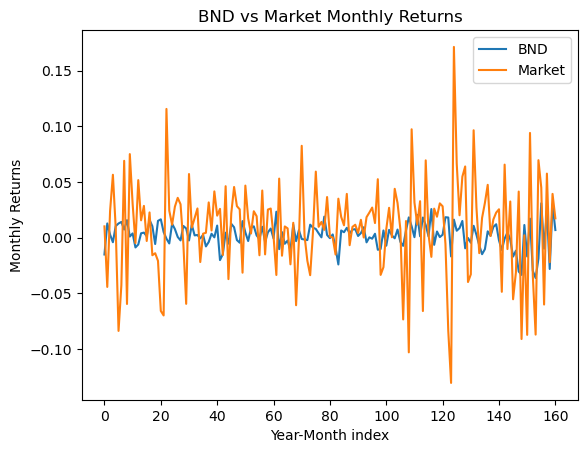

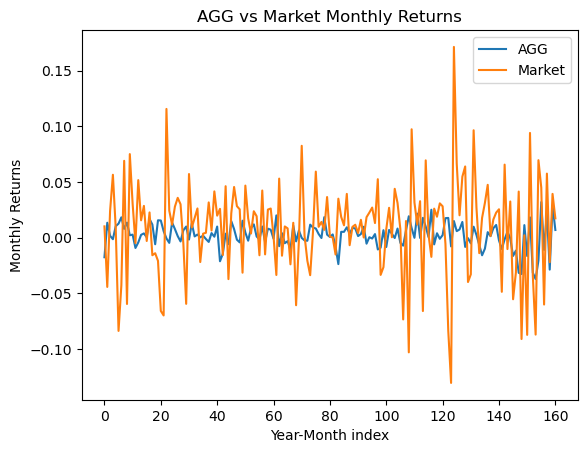

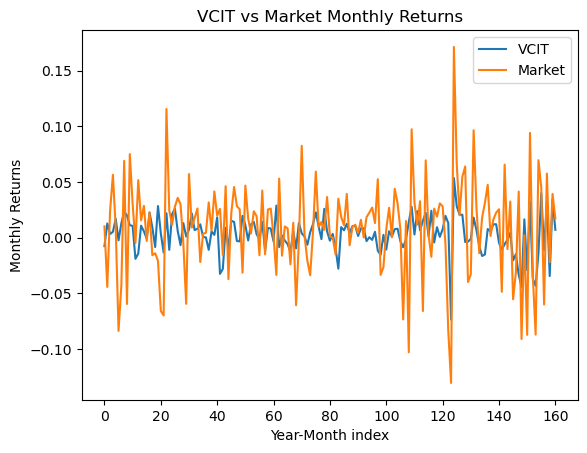

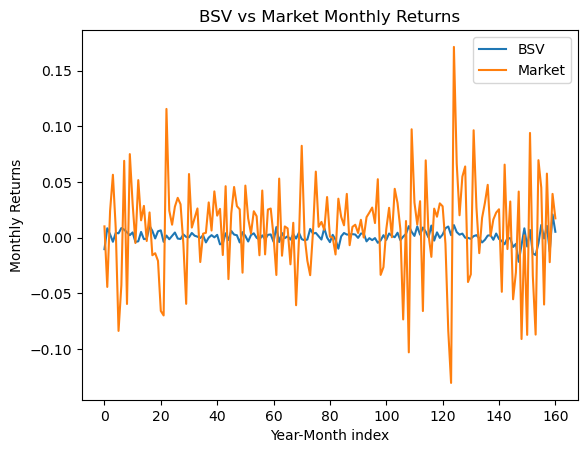

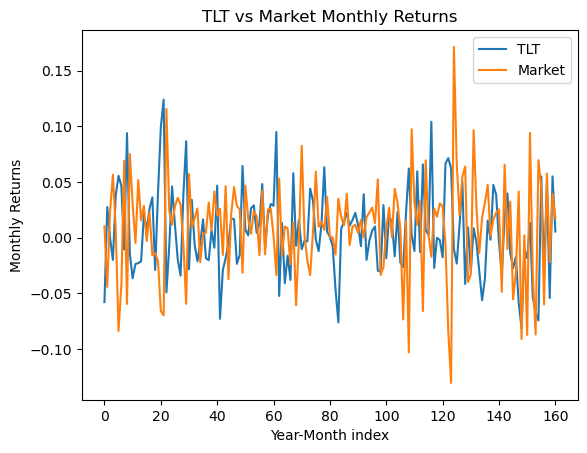

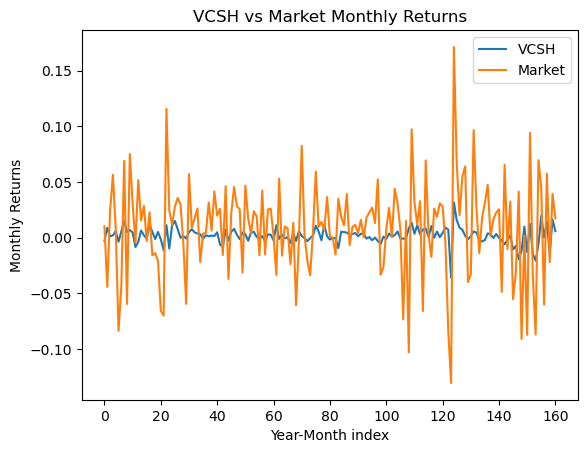

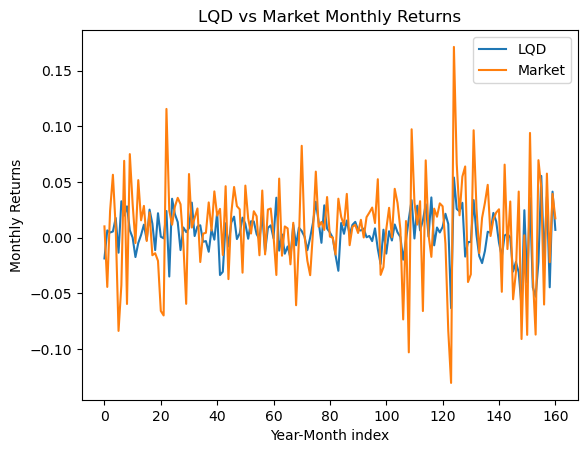

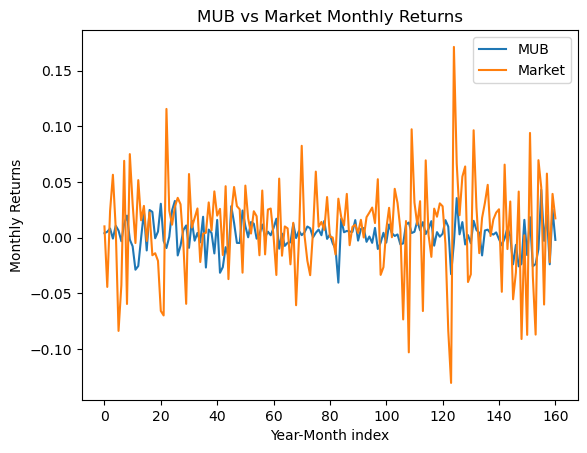

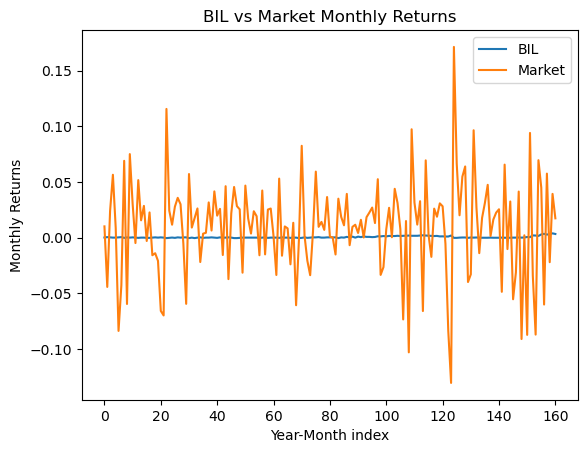

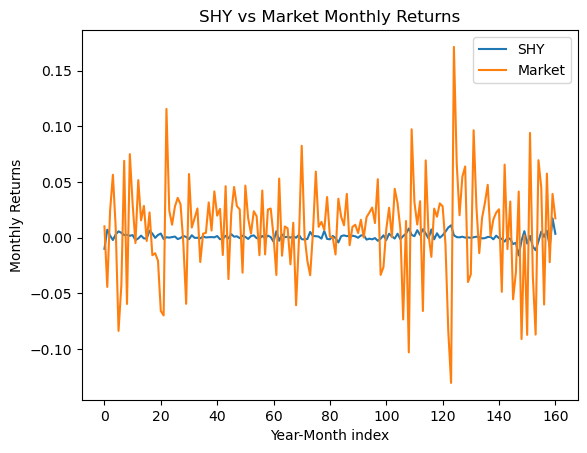

In [43]:
market_mr = []
for year_it in range(2009,2024):
    if year_it == 2009:
        month_start = 12
        month_end = 13
    elif year_it == 2023:
        month_start = 1
        month_end = 5
    else:
        month_start = 1
        month_end = 13
    for month_it in range(month_start,month_end):
        market_mr.append(monthly_rets[str(year_it)][str(month_it)]['Market'])

bond_to_mr_dict = {}

for bond in bond_etf_symbs:
    bond_specific_mr_dict = bond_mr[bond]
    y = bond_specific_mr_dict.values()
    bond_to_mr_dict[bond] = list(y)
    x = np.arange(0,len(y))
    plt.figure()
    plt.plot(x,y,label=bond)
    plt.plot(x,market_mr,label='Market')
    plt.xlabel('Year-Month index')
    plt.ylabel('Monthly Returns')
    plt.title(bond + ' vs Market Monthly Returns')
    plt.legend()

# Plot Bond ETF Annual Returns and SPY Annual Returns

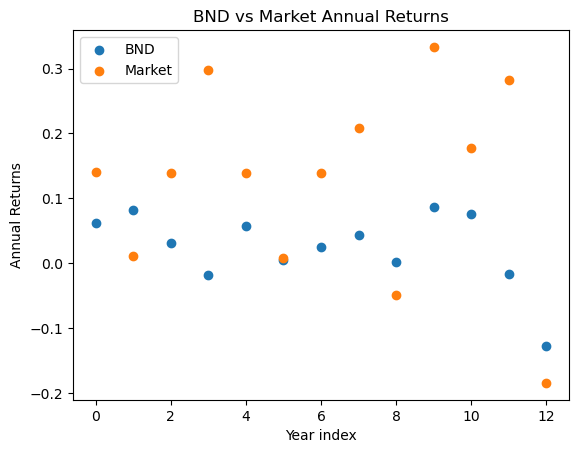

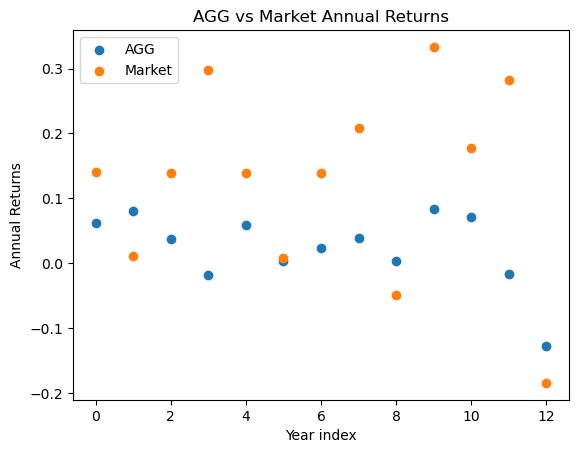

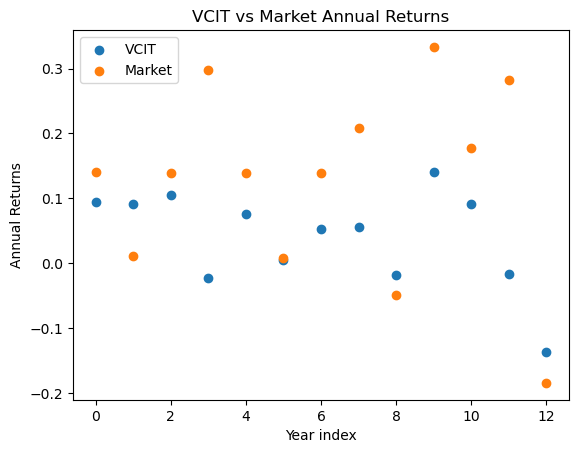

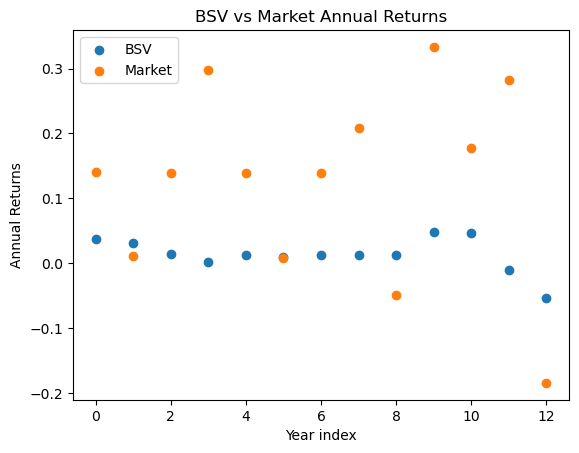

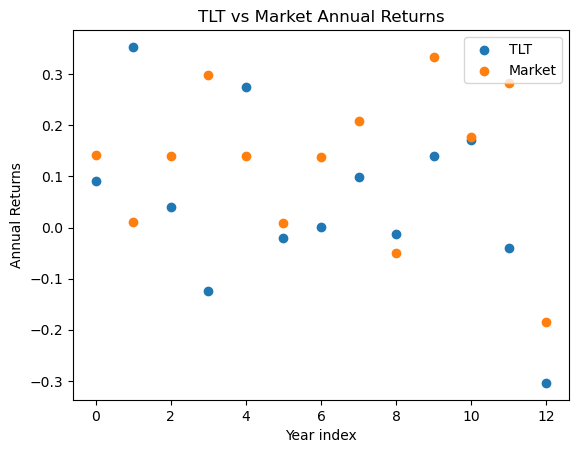

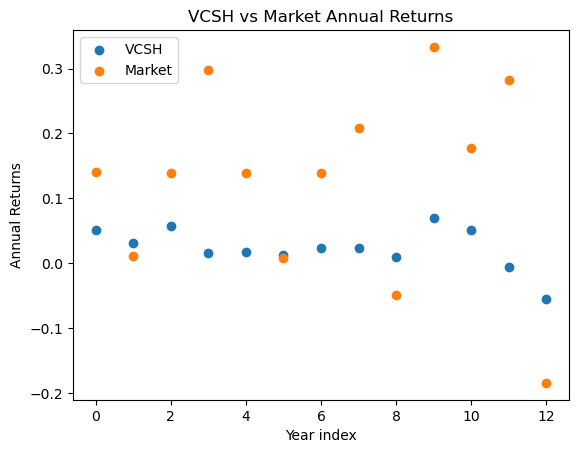

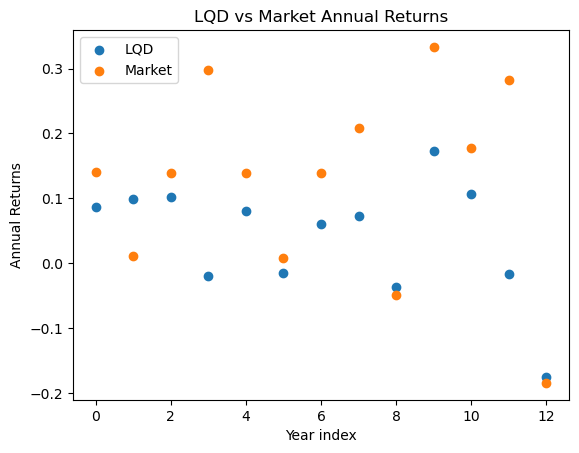

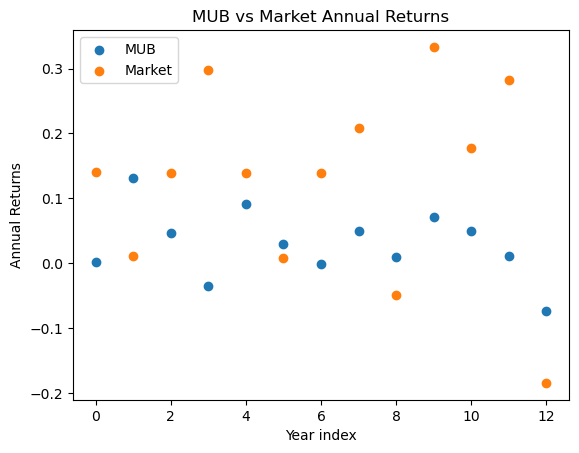

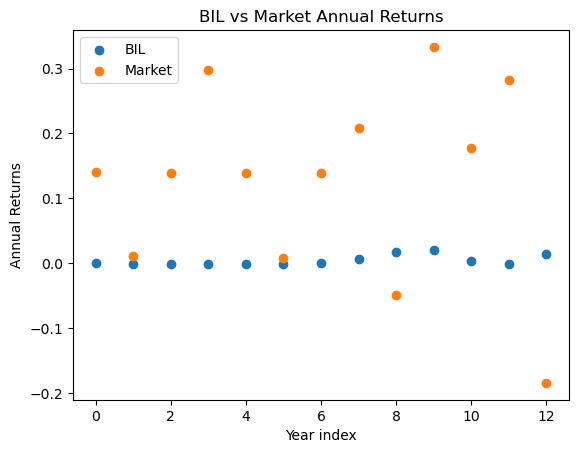

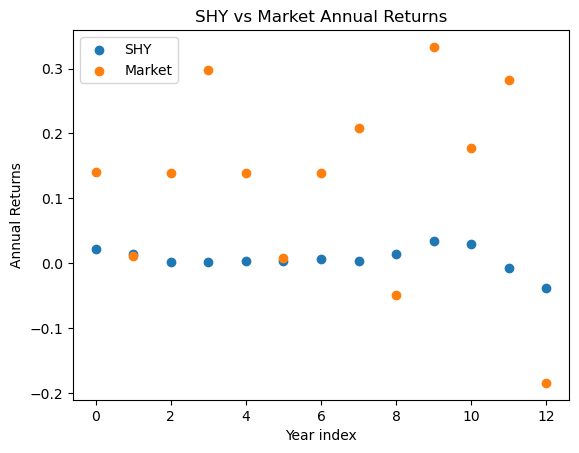

In [44]:
market_yr = []
for year_it in range(2010,2023):
    market_yr.append(yearly_rets[str(year_it)]['Market'])

bond_to_yr_dict = {}

for bond in bond_etf_symbs:
    bond_specific_yr_dict = bond_yr[bond]
    y = bond_specific_yr_dict.values()
    bond_to_yr_dict[bond]=list(y)
    x = np.arange(0,len(y))
    plt.figure()
    plt.scatter(x,y,label=bond)
    plt.scatter(x,market_yr,label='Market')
    plt.xlabel('Year index')
    plt.ylabel('Annual Returns')
    plt.title(bond + ' vs Market Annual Returns')
    plt.legend()

In [45]:
bond_to_mr_dict['Market'] = market_mr
bond_to_yr_dict['Market'] = market_yr
mr_df = pd.DataFrame(data=bond_to_mr_dict)
yr_df = pd.DataFrame(data=bond_to_yr_dict)

# Monthly Returns correlation (Bonds and Market)

In [49]:
mr_df.corr()['Market']

BND       0.162460
AGG       0.143819
VCIT      0.452086
BSV       0.106849
TLT      -0.245610
VCSH      0.493930
LQD       0.444316
MUB       0.123064
BIL      -0.146671
SHY      -0.078106
Market    1.000000
Name: Market, dtype: float64

# Annual Returns correlation (Bonds and Market)

In [50]:
yr_df.corr()['Market']

BND       0.498012
AGG       0.493369
VCIT      0.530687
BSV       0.483993
TLT       0.273435
VCSH      0.579302
LQD       0.606480
MUB       0.221479
BIL      -0.193751
SHY       0.490892
Market    1.000000
Name: Market, dtype: float64

In [51]:
mr_df.describe()

,BND,AGG,VCIT,BSV,TLT,VCSH,LQD,MUB,BIL,SHY,Market
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.000000,161.000000
mean,0.001933,0.001956,0.003172,0.001090,0.004721,0.001761,0.003259,0.002247,4.448352e-04,0.000707,0.008982
std,0.011488,0.011435,0.016708,0.005354,0.037675,0.007496,0.020030,0.013629,8.386337e-04,0.003641,0.043258
min,-0.036341,-0.037274,-0.073708,-0.021726,-0.081224,-0.035954,-0.063396,-0.040468,-4.374452e-04,-0.016055,-0.130594
25%,-0.003891,-0.003448,-0.004365,-0.001738,-0.020030,-0.001284,-0.004854,-0.004703,-1.678902e-07,-0.000828,-0.015072
50%,0.002512,0.002467,0.005221,0.001521,0.002020,0.001869,0.004622,0.003492,8.732913e-05,0.000580,0.013334
75%,0.009295,0.008678,0.012389,0.003873,0.026233,0.005343,0.014159,0.009984,6.558380e-04,0.002038,0.031077
max,0.030887,0.031916,0.053512,0.020819,0.124035,0.031684,0.055436,0.043009,3.826368e-03,0.017335,0.171385


In [52]:
yr_df.describe()

,BND,AGG,VCIT,BSV,TLT,VCSH,LQD,MUB,BIL,SHY,Market
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.023697,0.023537,0.040111,0.013685,0.051263,0.023352,0.040143,0.029688,0.004475,0.007199,0.126514
std,0.058046,0.057202,0.074868,0.026443,0.169306,0.032149,0.089724,0.053464,0.007657,0.017913,0.147548
min,-0.127932,-0.127079,-0.135946,-0.053117,-0.303985,-0.054911,-0.174608,-0.073376,-0.001094,-0.037789,-0.184056
25%,0.002634,0.004050,-0.016534,0.009184,-0.020773,0.012823,-0.016708,0.002403,-0.000655,0.002620,0.011230
50%,0.030767,0.038020,0.056146,0.013346,0.039788,0.023407,0.072655,0.030084,0.000000,0.004232,0.139386
75%,0.061852,0.062796,0.091959,0.031017,0.139777,0.051094,0.099638,0.050288,0.006451,0.014888,0.208888
max,0.087378,0.083946,0.140999,0.048782,0.353239,0.070202,0.173682,0.131334,0.020208,0.033684,0.333257


# Growth of $1 investment in Bond ETFs and the Market

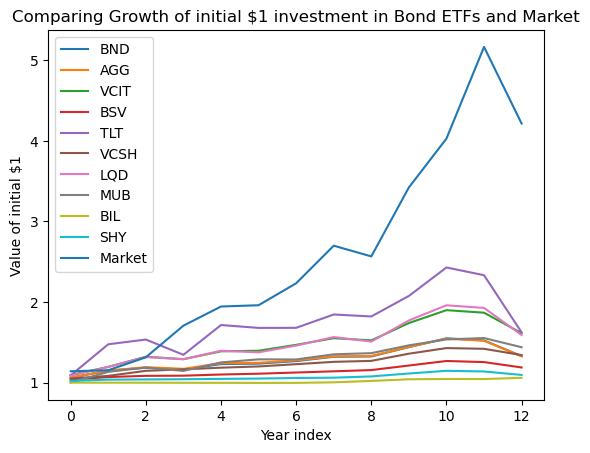

In [73]:
pv = {}
for bond in bond_etf_symbs:
    pv[bond] = [1]
pv['Market'] = [1]

for idx, row in yr_df.iterrows():
    for bond in bond_etf_symbs:
        pv[bond].append(pv[bond][-1]*(1+row[bond]))
    pv['Market'].append(pv['Market'][-1]*(1+row['Market']))

for bond in bond_etf_symbs:
    plt.plot(np.arange(0,len(pv[bond])-1),pv[bond][1:],label=bond)
plt.plot(np.arange(0,len(pv['Market'])-1),pv['Market'][1:],label='Market')
plt.xlabel('Year index')
plt.ylabel('Value of initial $1')
plt.title('Comparing Growth of initial $1 investment in Bond ETFs and Market')
plt.legend()

# General trend is that bond ETFs are less risky but provide lower average returns

# REITs

In [53]:
reit_symbs = ['VNQ','SCHH','VNQI','IYR']


In [54]:
for reit in reit_symbs:
    print(yf.Ticker(reit).history(period='max').index[0])

2004-09-29 00:00:00-04:00
2011-01-13 00:00:00-05:00
2010-11-01 00:00:00-04:00
2000-06-19 00:00:00-04:00


In [55]:
reit_mr_dict = {}
reit_yr_dict = {}

for reit in reit_symbs:
    df = yf.Ticker(reit).history(start='2011-01-13')
    index = df.index
    months = []
    years = []
    for dt in index:
        months.append(dt.month)
        years.append(dt.year)
    df['Month'] = pd.Series(months,index=index)
    df['Year'] = pd.Series(years,index=index)
    df.reset_index(drop=True,inplace=True)
    df_yr_gpo = df.groupby(['Year'])
    df_mon_gpo = df.groupby(['Year','Month'])
    reit_mr_dict[reit] = {}
    reit_yr_dict[reit] = {}
    for year_it in range(2011,2024):
        
        if year_it == 2023:
            end_month = 5
        else:
            end_month = 13
        if year_it == 2011:
            start_month = 2
        else:
            start_month = 1
        
        for month_it in range(start_month,end_month):
            
            group = df_mon_gpo.get_group((year_it,month_it))
            fd = group.head(1)
            ld = group.tail(1)
            ret = (ld['Close'].iloc[0]-fd['Open'].iloc[0])/fd['Open'].iloc[0]
            reit_mr_dict[reit][(year_it,month_it)] = ret
    
    for year_it in range(2011,2023):
        
        group = df_yr_gpo.get_group(year_it)
        fd = group.head(1)
        ld = group.tail(1)
        ret = (ld['Close'].iloc[0]-fd['Open'].iloc[0])/fd['Open'].iloc[0]
        reit_yr_dict[reit][year_it] = ret
        
        
        

# Plot REIT ETF monthly returns and Market monthly returns

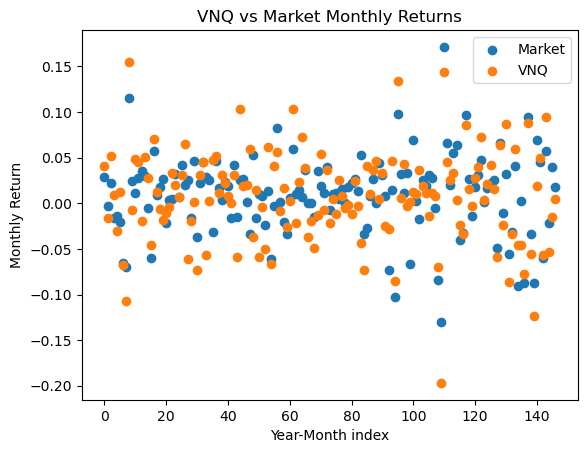

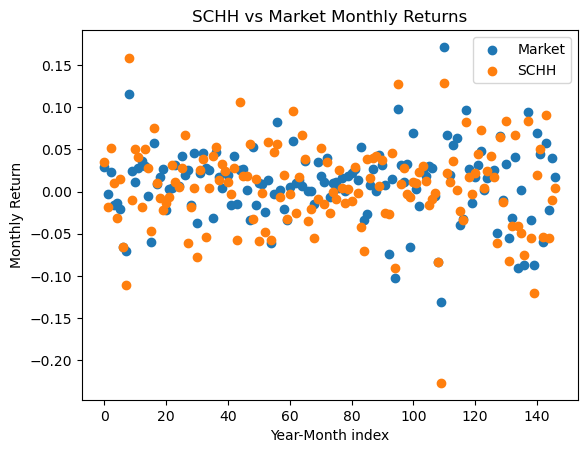

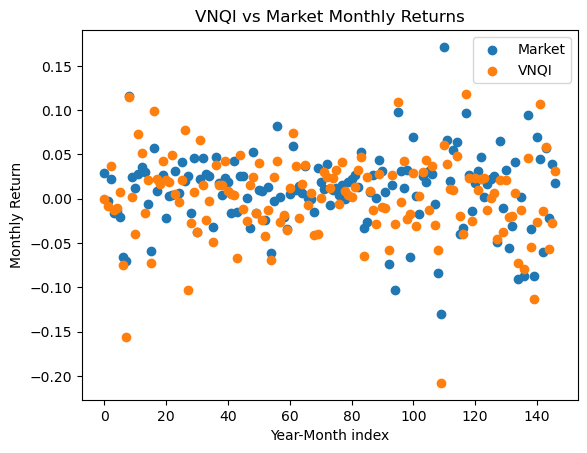

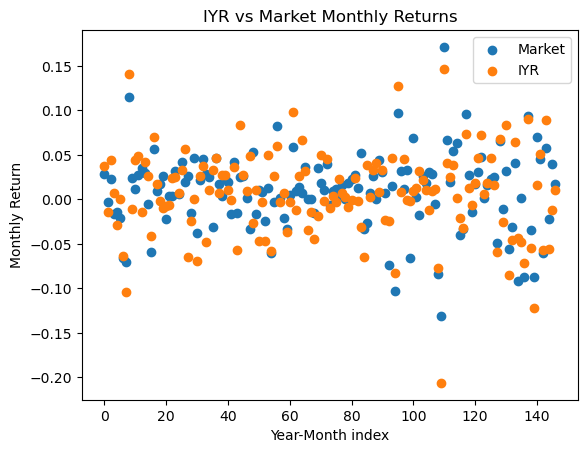

In [60]:
market_mr = []
for year_it in range(2011,2024):
    
    if year_it == 2023:
            end_month = 5
    else:
        end_month = 13
    if year_it == 2011:
        start_month = 2
    else:
        start_month = 1
    
    for month_it in range(start_month,end_month):
        market_mr.append(monthly_rets[str(year_it)][str(month_it)]['Market'])


reit_to_mr_dict = {}
reit_to_mr_dict['Market'] = market_mr

for reit in reit_symbs:
    plt.figure()
    plt.scatter(np.arange(0,len(market_mr)),market_mr,label='Market')
    plt.scatter(np.arange(0,len(market_mr)),reit_mr_dict[reit].values(),label=reit)
    reit_to_mr_dict[reit] = list(reit_mr_dict[reit].values())
    plt.xlabel('Year-Month index')
    plt.ylabel('Monthly Return')
    plt.title(reit + ' vs Market Monthly Returns')
    plt.legend()



# Plot REIT ETF annual returns and Market annual returns

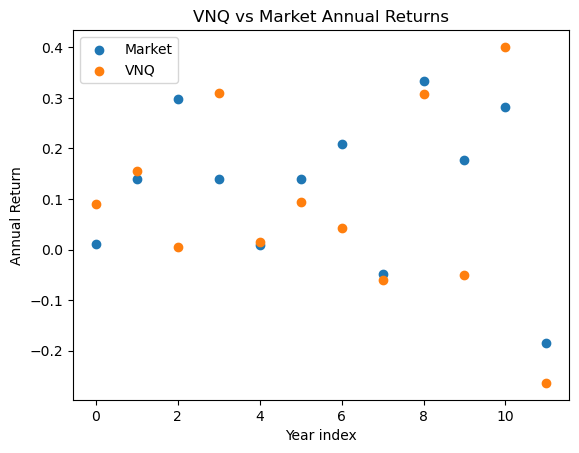

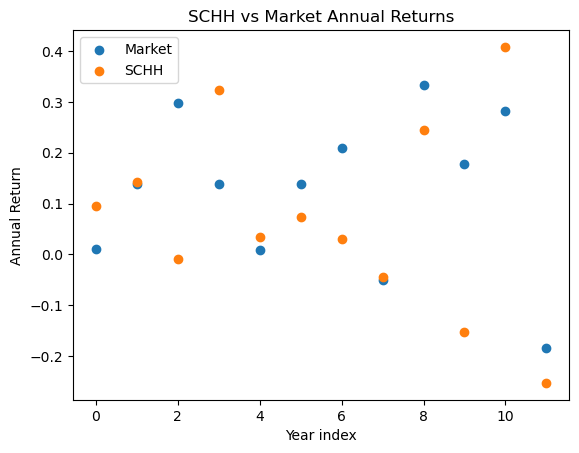

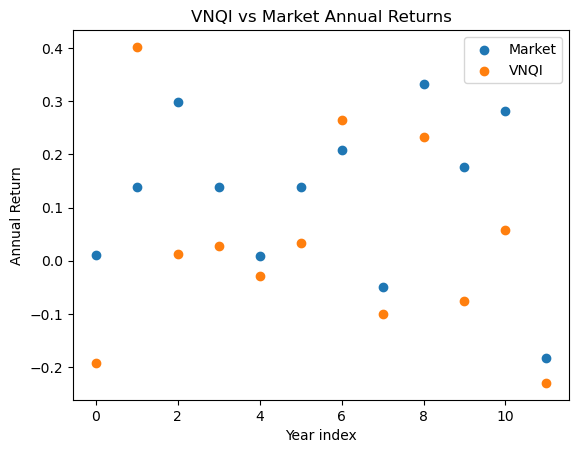

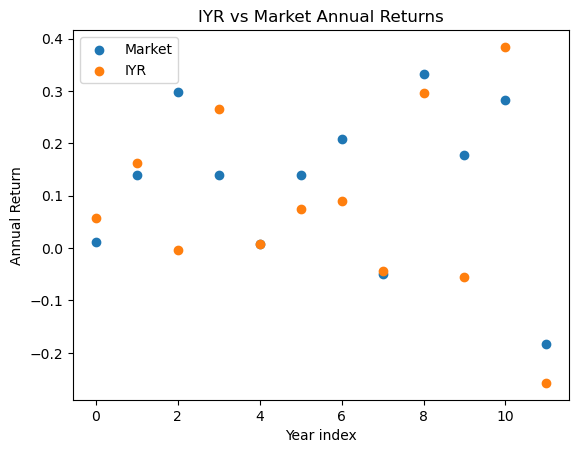

In [62]:
market_yr = []
for year_it in range(2011,2023):
    market_yr.append(yearly_rets[str(year_it)]['Market'])


reit_to_yr_dict = {}
reit_to_yr_dict['Market'] = market_yr

for reit in reit_symbs:
    plt.figure()
    plt.scatter(np.arange(0,len(market_yr)),market_yr,label='Market')
    plt.scatter(np.arange(0,len(market_yr)),reit_yr_dict[reit].values(),label=reit)
    reit_to_yr_dict[reit] = list(reit_yr_dict[reit].values())
    plt.xlabel('Year index')
    plt.ylabel('Annual Return')
    plt.title(reit + ' vs Market Annual Returns')
    plt.legend()




In [63]:
reit_mr_df = pd.DataFrame(reit_to_mr_dict)
reit_yr_df = pd.DataFrame(reit_to_yr_dict)

# REIT correlation of monthly returns to market

In [64]:
reit_mr_df.corr()['Market']

Market    1.000000
VNQ       0.740306
SCHH      0.741426
VNQI      0.724302
IYR       0.767359
Name: Market, dtype: float64

# REIT correlation of annual returns to market

In [65]:
reit_yr_df.corr()['Market']

Market    1.000000
VNQ       0.688850
SCHH      0.583427
VNQI      0.625768
IYR       0.713654
Name: Market, dtype: float64

In [66]:
reit_mr_df.describe()

,Market,VNQ,SCHH,VNQI,IYR
count,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.009121,0.006657,0.005256,0.001660,0.006269
std,0.042810,0.050415,0.050730,0.046254,0.048561
min,-0.130594,-0.196861,-0.226913,-0.208010,-0.206224
25%,-0.014546,-0.020432,-0.021460,-0.023194,-0.016292
50%,0.013334,0.008377,0.008380,0.006283,0.007784
75%,0.030936,0.038024,0.035921,0.026899,0.034947
max,0.171385,0.154946,0.158394,0.118368,0.146540


In [67]:
reit_yr_df.describe()

,Market,VNQ,SCHH,VNQI,IYR
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.125303,0.087365,0.074391,0.033499,0.081633
std,0.154042,0.185514,0.188414,0.186958,0.176184
min,-0.184056,-0.263781,-0.252497,-0.230088,-0.257446
25%,0.010478,-0.008228,-0.017955,-0.081881,-0.013373
50%,0.139201,0.067194,0.053288,0.019980,0.066064
75%,0.227262,0.193264,0.168179,0.100841,0.188747
max,0.333257,0.400917,0.408122,0.402294,0.384048


It looks like REITs have been more volatile while also not providing as much in average return 

# Growth of $1 investment in Market and in the REITs

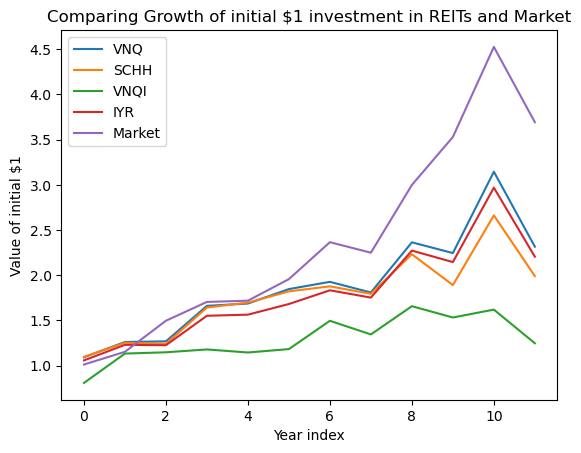

In [70]:
pv = {}
for reit in reit_symbs:
    pv[reit] = [1]
pv['Market'] = [1]

for idx, row in reit_yr_df.iterrows():
    for reit in reit_symbs:
        pv[reit].append(pv[reit][-1]*(1+row[reit]))
    pv['Market'].append(pv['Market'][-1]*(1+row['Market']))

for reit in reit_symbs:
    plt.plot(np.arange(0,len(pv[reit])-1),pv[reit][1:],label=reit)
plt.plot(np.arange(0,len(pv['Market'])-1),pv['Market'][1:],label='Market')
plt.xlabel('Year index')
plt.ylabel('Value of initial $1')
plt.title('Comparing Growth of initial $1 investment in REITs and Market')
plt.legend()

# Commodities

In [78]:
comm_symbs = ['PDBC','FTGC','DBC','GSG']

In [79]:
for comm in comm_symbs:
    print(yf.Ticker(comm).history(period='max').index[0])

2014-11-07 00:00:00-05:00
2013-10-23 00:00:00-04:00
2006-02-06 00:00:00-05:00
2006-07-21 00:00:00-04:00


In [81]:
comm_mr_dict = {}
comm_yr_dict = {}

for comm in comm_symbs:
    df = yf.Ticker(comm).history(start='2014-11-07')
    index = df.index
    months = []
    years = []
    for dt in index:
        months.append(dt.month)
        years.append(dt.year)
    df['Month'] = pd.Series(months,index=index)
    df['Year'] = pd.Series(years,index=index)
    df.reset_index(drop=True,inplace=True)
    df_yr_gpo = df.groupby(['Year'])
    df_mon_gpo = df.groupby(['Year','Month'])
    comm_mr_dict[comm] = {}
    comm_yr_dict[comm] = {}
    
    for year_it in range(2014,2024):
        
        if year_it == 2023:
            end_month = 5
        else:
            end_month = 13
        if year_it == 2014:
            start_month = 11
        else:
            start_month = 1
        
        for month_it in range(start_month,end_month):
            
            group = df_mon_gpo.get_group((year_it,month_it))
            fd = group.head(1)
            ld = group.tail(1)
            ret = (ld['Close'].iloc[0]-fd['Open'].iloc[0])/fd['Open'].iloc[0]
            comm_mr_dict[comm][(year_it,month_it)] = ret
    
    for year_it in range(2015,2023):
        
        group = df_yr_gpo.get_group(year_it)
        fd = group.head(1)
        ld = group.tail(1)
        ret = (ld['Close'].iloc[0]-fd['Open'].iloc[0])/fd['Open'].iloc[0]
        comm_yr_dict[comm][year_it] = ret
        

# Plot Commodity ETF monthly returns and Market monthly returns

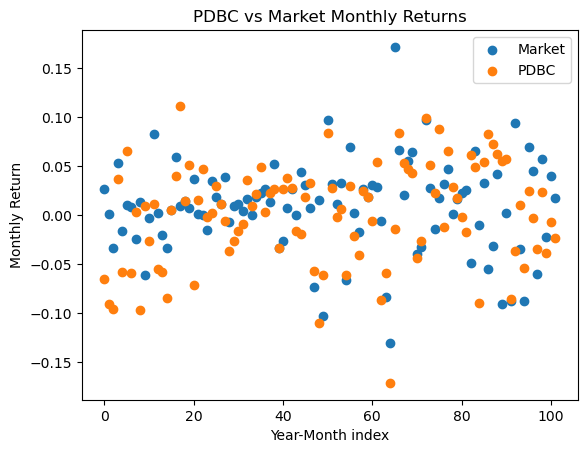

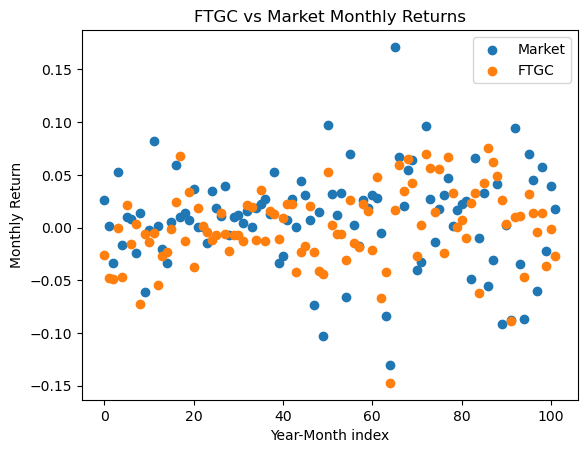

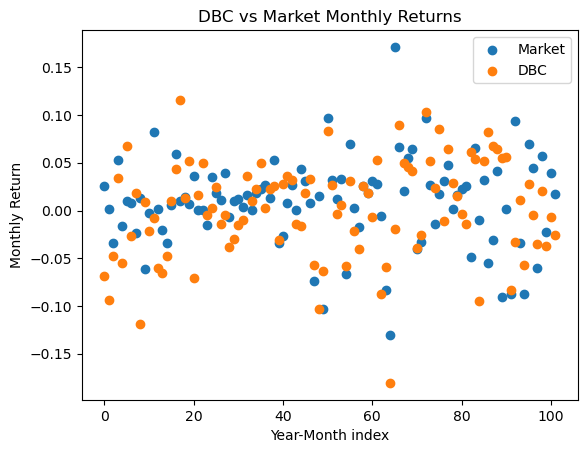

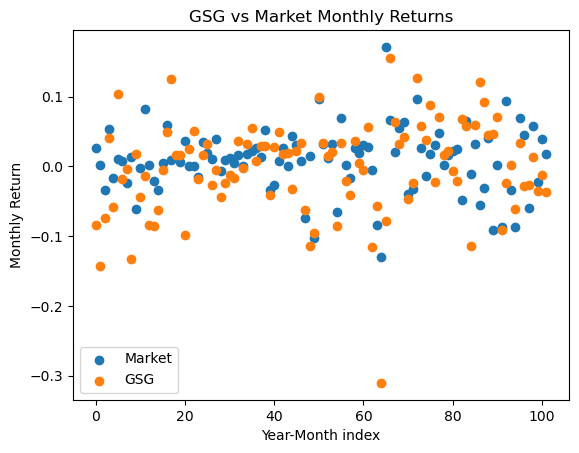

In [82]:
market_mr = []

for year_it in range(2014,2024):
    
    if year_it == 2023:
            end_month = 5
    else:
        end_month = 13
    if year_it == 2014:
        start_month = 11
    else:
        start_month = 1
    
    for month_it in range(start_month,end_month):
        market_mr.append(monthly_rets[str(year_it)][str(month_it)]['Market'])


comm_to_mr_dict = {}
comm_to_mr_dict['Market'] = market_mr

for comm in comm_symbs:
    plt.figure()
    plt.scatter(np.arange(0,len(market_mr)),market_mr,label='Market')
    plt.scatter(np.arange(0,len(market_mr)),comm_mr_dict[comm].values(),label=comm)
    comm_to_mr_dict[comm] = list(comm_mr_dict[comm].values())
    plt.xlabel('Year-Month index')
    plt.ylabel('Monthly Return')
    plt.title(comm + ' vs Market Monthly Returns')
    plt.legend()



In [83]:
comm_mr_df = pd.DataFrame(data=comm_to_mr_dict)

# Commodities Monthly Returns correlation with Market 

In [84]:
comm_mr_df.corr()['Market']

Market    1.000000
PDBC      0.422957
FTGC      0.471045
DBC       0.410747
GSG       0.389754
Name: Market, dtype: float64

In [85]:
comm_mr_df.describe()

,Market,PDBC,FTGC,DBC,GSG
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.008314,0.000644,0.000251,0.001347,-0.001928
std,0.046342,0.052028,0.037067,0.051737,0.067141
min,-0.130594,-0.171108,-0.147463,-0.180626,-0.310600
25%,-0.014854,-0.034212,-0.022107,-0.030158,-0.036829
50%,0.011637,0.007886,-0.001114,0.007314,0.006174
75%,0.031486,0.036162,0.022045,0.035932,0.036805
max,0.171385,0.111475,0.075652,0.115532,0.155294


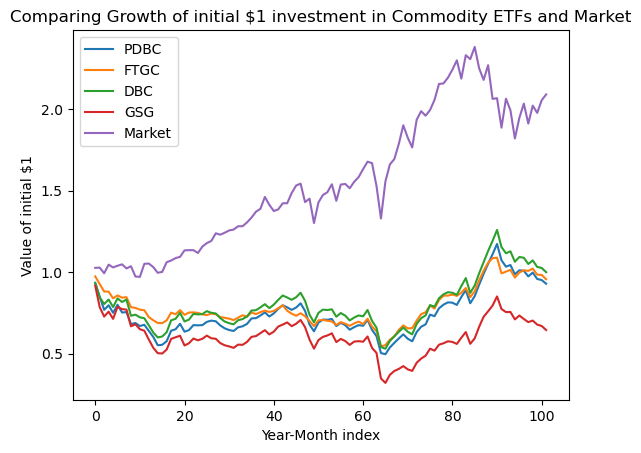

In [86]:
pv = {}
for comm in comm_symbs:
    pv[comm] = [1]
pv['Market'] = [1]

for idx, row in comm_mr_df.iterrows():
    for comm in comm_symbs:
        pv[comm].append(pv[comm][-1]*(1+row[comm]))
    pv['Market'].append(pv['Market'][-1]*(1+row['Market']))

for comm in comm_symbs:
    plt.plot(np.arange(0,len(pv[comm])-1),pv[comm][1:],label=comm)
plt.plot(np.arange(0,len(pv['Market'])-1),pv['Market'][1:],label='Market')
plt.xlabel('Year-Month index')
plt.ylabel('Value of initial $1')
plt.title('Comparing Growth of initial $1 investment in Commodity ETFs and Market')
plt.legend()